### Part 2: Calculating the F-F curve of DPI neurons

In the second part, we will calculate the F-F curve of silicon neurons. In neuroscience, the F-F curve is a function that relates to the input firing rate and the output firing rate of a neuron. Because the F-F curve only specifies the firing rate rather than exact spike times, it is a concept suited to the rate coding rather than the temporal coding model of neuronal computation. To obtain the F-F curve, we will simulate silicon neurons with a range of spike frequencies and observe the output behavior.

In [16]:
import os
import sys 
sys.path.append('..')

from Network_sim import *
from brian2 import *
from DynapSE import DynapSE
from equations.dynapse_eq import *
from parameters.dynapse_param import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline 
mpl.rcParams['figure.dpi'] = 90  
set_device('cpp_standalone')

In [17]:
def FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf):
     #creates a simulation of 200 neurons each with an AMPA synapse spanning the
     #frequency ranges delinated with freq_start and stop. So the divisions are
     #of 200.

    device.reinit()
    device.activate()
    defaultclock.dt = 20 * us
    # Ignore Brian2 base warnings
    BrianLogger.suppress_name('base')

    # Create a Brian2 network and chip instance using that monitors Dynap-SE1 resources.
    network = Network()
    chip = DynapSE(network)

    # Create [time_steps, source ID] matrix, where firing rate is defined by source ID.
    # e.g., source 5 will fire at 5 Hz.
    rates2 = np.tile(np.linspace(freq_start, freq_stop, 200), (inp_duration*1000, 1)) # shape: (inp_duration*1000, 256)

    # Create a TimedArray according to rate information
    spike_timing = TimedArray(rates2 * Hz , dt=1 * us) 

    # Using spike timing function, generate a Spike Generator that creates Poisson spikes
    input_spike_generator = PoissonGroup(200, "spike_timing(t,i)")

    # Allocate neurons such that each firing frequency will be assigned to single neuron.
    DPI_neuron  = chip.get_neurons(200, 'Core_1')
    DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA')

    # One-to-one (j=i) mapping, instead of all-to-all connection
    chip.connect(DPI_synapse, j='i')
    DPI_synapse.weight = 0.7

    core_conf = {**ampa_conf,**adaptation_conf}
        # set the params
    chip.set_bias(core_conf, 'Core_1')

    # Monitors
    mon_neuron_input_PC = SpikeMonitor(input_spike_generator, name='mon_neuron_input_PC')
    mon_neuron_output_PC = SpikeMonitor(DPI_neuron, name='mon_neuron_output_PC')
    network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input_PC, mon_neuron_output_PC])

    # Simulation
    network.run(inp_duration * 1000 * ms)

    return np.asanyarray(mon_neuron_output_PC.count)

In [21]:
## Calculating the F-F curve of DPI neurons
##################
inp_duration   = 5     # second - Simulation duration (default: 5)
freq_start     = 0     # Hz - Starting frequency (Neuron 0 will be stimulated with this Poisson rate) (default: 0)
freq_stop      = 1000   # Hz - Stop frequency (The last neuron will be stimulated with this Poisson rate) (default: 200)
##################

adaptation_conf = {
    "Isoma_dpi_tau" :  2.8* pA,
    "Isoma_th"  : 200*pA,  
    "alpha_soma": 1,

    "Isoma_ahp_tau": 3 * pA,             
    "Isoma_ahp_w" : 70 * pA,

    "alpha_ahp"  : 2,  
    "soma_refP": 10 * ms,

    "Isoma_const": 150 *pA
                  }

ampa_conf = {"Iampa_tau": 5 * pA,
            "alpha_ampa": 4,
            "Iampa_w0": 20 * pA}


200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


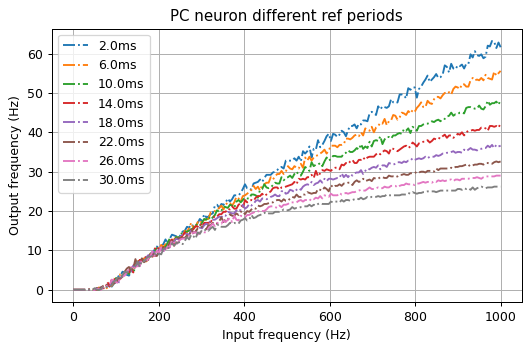

In [19]:
steps=8
param_list=linspace(2,30,steps)
output_array=[]
for param in param_list:    
    dict={'soma_refP':param*ms}
    adaptation_conf.update(dict)
    output_array.append(FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf))


for k in range(steps):
    plot(np.linspace(freq_start, freq_stop, 200),output_array[k]/ inp_duration * 1000 * ms,'-.',label=str(param_list[k])+"ms") # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'PC neuron different ref periods')
plt.legend()
plt.grid(True)
plt.tight_layout()

200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


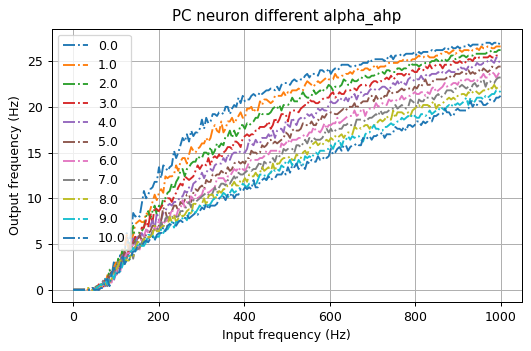

In [5]:
steps=11
param_list=linspace(0,10,steps)
output_array=[]
for param in param_list:    
    dict={'alpha_ahp':param}
    adaptation_conf.update(dict)
    output_array.append(FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf))


for k in range(steps):
    plot(np.linspace(freq_start, freq_stop, 200),output_array[k]/ inp_duration * 1000 * ms,'-.',label=str(param_list[k])) # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'PC neuron different alpha_ahp')
plt.legend()
plt.grid(True)
plt.tight_layout()

200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


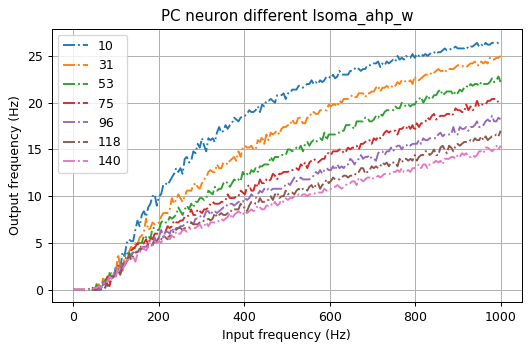

In [6]:
steps=7
param_list=linspace(10,140,steps)
output_array=[]
for param in param_list:    
    dict={'Isoma_ahp_w':param*pA}
    adaptation_conf.update(dict)
    output_array.append(FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf))


for k in range(steps):
    plot(np.linspace(freq_start, freq_stop, 200),output_array[k]/ inp_duration * 1000 * ms,'-.',label=str(int(param_list[k]))) # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'PC neuron different Isoma_ahp_w')
plt.legend()
plt.grid(True)
plt.tight_layout()

200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


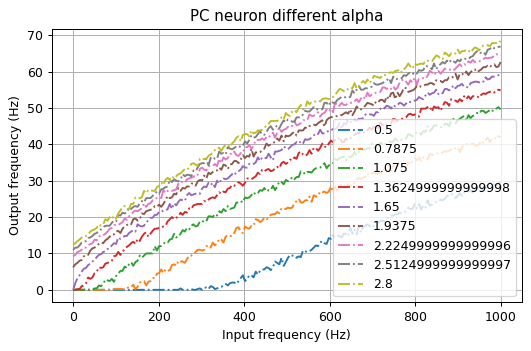

In [22]:
steps=9
param_list=linspace(.5,2.8,steps)
output_array=[]
for param in param_list:    
    dict={'alpha_soma':param}
    adaptation_conf.update(dict)
    output_array.append(FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf))


for k in range(steps):
    plot(np.linspace(freq_start, freq_stop, 200),output_array[k]/ inp_duration * 1000 * ms,'-.',label=str(param_list[k])) # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'PC neuron different alpha')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [23]:
adaptation_conf = {
    "Isoma_dpi_tau" :  7.5* pA,
    "Isoma_th"  : 3* nA,  
    "alpha_soma": 2.7,
    
    "Isoma_ahp_tau": 0 * pA,             
    "Isoma_ahp_w" : 0 * pA,
    "alpha_ahp"  : 1,  
    
    "soma_refP": 2.5 * ms,
    "Isoma_const": 150 *pA
                }

After the simulation, we can calculate each neuron's firing rate by looking at the number of spikes it generates throughout the simulation.

200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


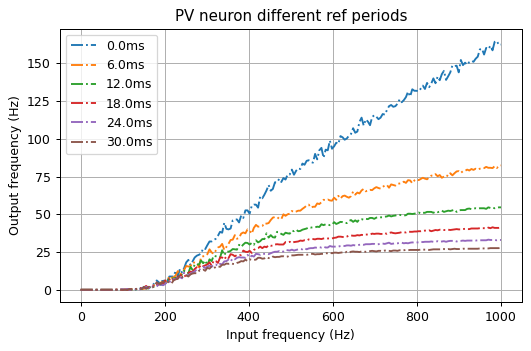

In [9]:
steps=6
param_list=linspace(0,30,steps)
output_array=[]
for param in param_list:    
    dict={'soma_refP':param*ms}
    adaptation_conf.update(dict)
    output_array.append(FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf))


for k in range(steps):
    plot(np.linspace(freq_start, freq_stop, 200),output_array[k]/ inp_duration * 1000 * ms,'-.',label=str(param_list[k])+"ms") # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'PV neuron different ref periods')
plt.legend()
plt.grid(True)
plt.tight_layout()
    

200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


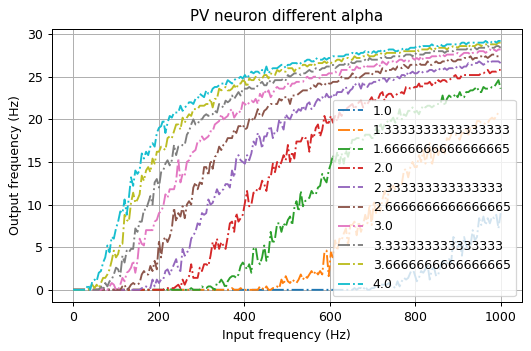

In [10]:
steps=10
param_list=linspace(1,4,steps)
output_array=[]
for param in param_list:    
    dict={"alpha_soma":param}
    adaptation_conf.update(dict)
    output_array.append(FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf))

for k in range(steps):
    plot(np.linspace(freq_start, freq_stop, 200),output_array[k]/ inp_duration * 1000 * ms,'-.',label=str(param_list[k])) # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'PV neuron different alpha')
plt.legend()
plt.grid(True)
plt.tight_layout()
    

200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


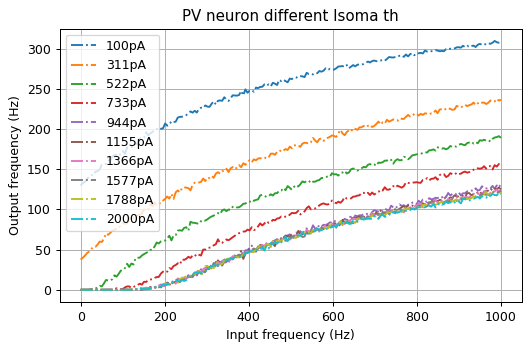

In [24]:
steps=10
param_list=linspace(100,2000,steps)
output_array=[]
for param in param_list:    
    dict={"Isoma_th":param*pA}
    adaptation_conf.update(dict)
    output_array.append(FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf))


for k in range(steps):
    plot(np.linspace(freq_start, freq_stop, 200),output_array[k]/ inp_duration * 1000 * ms,'-.',label=str(int(param_list[k]))+"pA") # Count number of spikes per neuron
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'PV neuron different Isoma th')
plt.legend()
plt.grid(True)
plt.tight_layout()

This is the end of Part 2.

200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


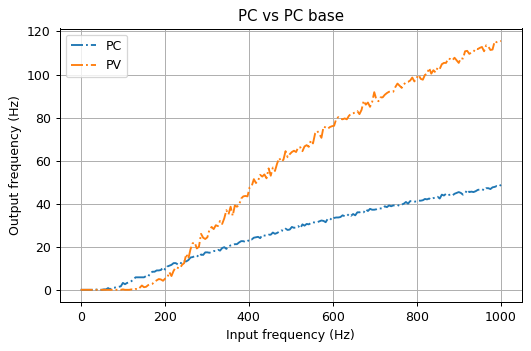

In [12]:
adaptation_conf = {
    "Isoma_dpi_tau" :  2.8* pA,
    "Isoma_th"  : 200*pA,  
    "alpha_soma": 1,

    "Isoma_ahp_tau": 3 * pA,             
    "Isoma_ahp_w" : 70 * pA,

    "alpha_ahp"  : 2,  
    "soma_refP": 10 * ms,

    "Isoma_const": 150 *pA
                }

                
ampa_conf = {"Iampa_tau": 5 * pA,
            "alpha_ampa": 4,
            "Iampa_w0": 20 * pA}


PC_output= FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf)


adaptation_conf = {
    "Isoma_dpi_tau" :  7.5* pA,
    "Isoma_th"  : 3* nA,  
    "alpha_soma": 2.7,
    
    "Isoma_ahp_tau": 0 * pA,             
    "Isoma_ahp_w" : 0 * pA,
    "alpha_ahp"  : 1,  
    
    "soma_refP": 2.5 * ms,
    "Isoma_const": 150 *pA
                }


PV_output= FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf)

plot(np.linspace(freq_start, freq_stop, 200),PC_output/ inp_duration * 1000 * ms,'-.',label="PC") # Count number of spikes per neuron
plot(np.linspace(freq_start, freq_stop, 200),PV_output/ inp_duration * 1000 * ms,'-.',label="PV") # Count number of spikes per neuron

plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'PC vs PC base')
plt.legend()
plt.grid(True)
plt.tight_layout()

200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
200 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


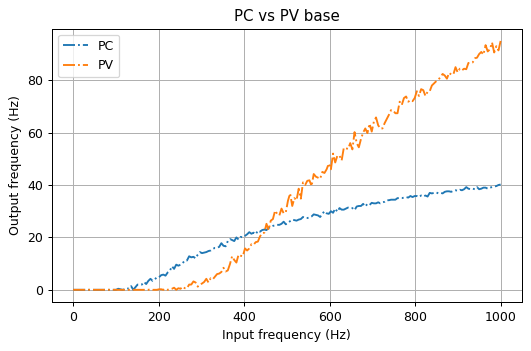

In [13]:
adaptation_conf = {
    "Isoma_dpi_tau" :  2.8* pA,
    "Isoma_th"  : 200*pA,  
    "alpha_soma": .8,

    "Isoma_ahp_tau": 3 * pA,             
    "Isoma_ahp_w" : 50 * pA,

    "alpha_ahp"  : 1,  
    "soma_refP": 15 * ms,

    "Isoma_const": 150 *pA
                }

                
ampa_conf = {"Iampa_tau": 5 * pA,
            "alpha_ampa": 4,
            "Iampa_w0": 20 * pA}


PC_output= FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf)


adaptation_conf = {
    "Isoma_dpi_tau" :  7.5* pA,
    "Isoma_th"  : 3* nA,  
    "alpha_soma": 2,
    
    "Isoma_ahp_tau": 0 * pA,             
    "Isoma_ahp_w" : 0 * pA,
    "alpha_ahp"  : 1,  
    
    "soma_refP": 2 * ms,
    "Isoma_const": 150 *pA
                }


PV_output= FF_single_neuron(freq_start,freq_stop,inp_duration,ampa_conf,adaptation_conf)

plot(np.linspace(freq_start, freq_stop, 200),PC_output/ inp_duration * 1000 * ms,'-.',label="PC") # Count number of spikes per neuron
plot(np.linspace(freq_start, freq_stop, 200),PV_output/ inp_duration * 1000 * ms,'-.',label="PV") # Count number of spikes per neuron

plt.xlabel('Input frequency (Hz)')
plt.ylabel('Output frequency (Hz)')
plt.title(f'PC vs PV base')
plt.legend()
plt.grid(True)
plt.tight_layout()